In [3]:
#pip install pyathena

In [4]:
# ESTA QUERY INCORPORA EL ID_FRAG_RECEIVER Y NO PONE A 0 AMOUNT CUANDO HAY FLAG=C (SI DEJA AMOUNT =0 CUANDO FLAG=A)

from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://viamericas-datalake-dev-us-east-1-283731589572-athena/queryresults/',
               region_name='us-east-1')
df = pd.read_sql(''' 
SELECT
    CAST(RTRIM(p.NAME_MAIN_BRANCH) AS VARCHAR(60)) AS PAYER,
    RTRIM(co.NAME_COUNTRY) AS COUNTRY,
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE) AS DATE,
    SUM(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.NET_AMOUNT_RECEIVER END) AS AMOUNT,
    RTRIM(A.ID_FLAG_RECEIVER) AS FLAG
FROM
    AwsDataCatalog.viamericas.RECEIVER a
    INNER JOIN AwsDataCatalog.viamericas.GROUP_BRANCH p ON p.ID_MAIN_BRANCH = CASE WHEN a.ID_MAIN_BRANCH_EXPIRED IS NULL THEN RTRIM(a.ID_MAIN_BRANCH_SENT) ELSE RTRIM(a.ID_MAIN_BRANCH_EXPIRED) END
    INNER JOIN AwsDataCatalog.viamericas.COUNTRY co ON a.ID_COUNTRY_RECEIVER = co.ID_COUNTRY
    LEFT JOIN AwsDataCatalog.viamericas.BRANCH b ON a.ID_BRANCH = b.ID_BRANCH
WHERE
    NOT (A.ID_MAIN_BRANCH_SENT LIKE 'M%')
    AND NOT (A.ID_BRANCH LIKE 'T%')
    AND SUBSTRING(b.id_branch, 1, 1) IN (SELECT SUBSTRING(PREFIX, 1, 1) FROM AwsDataCatalog.viamericas.BRANCH_PREFIX P WHERE TRIM(B.ID_COUNTRY) = TRIM(P.ID_COUNTRY))
    AND A.DATE_RECEIVER >= TIMESTAMP '2020-12-31 00:00:00.000'
    AND A.DATE_RECEIVER < TIMESTAMP '2023-10-31 00:00:00.000'
    AND b.ID_LOCATION IS NOT NULL
    AND b.ID_LOCATION NOT IN ('MD0010', 'MD0952', 'AK0003', 'CA3897', 'NY1130', 'MD0696', 'FL1933', 'AK0004', 'CA4046', 'NY1221', 'MD0623', 'MD1003', 'MD1018', 'AK0008', 'CA4291', 'NY1346', 'CA4350', 'NY1381','OK0236','FL2287','CA4391','AK0009', 'NY1397','CA4392','AK0010','FL2288','NY1399','AK0012','CA4396','NY1402','FL2289','AK0013', 'CA4418','NY1410','FL2301','AK0014', 'CA4428', 'NY1413')
GROUP BY
    RTRIM(p.NAME_MAIN_BRANCH),
    RTRIM(co.NAME_COUNTRY),
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE),
    RTRIM(A.ID_FLAG_RECEIVER)

''', conn)

/tmp/ipykernel_21/2489263810.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('''


In [5]:
df.head()

,PAYER,COUNTRY,DATE,AMOUNT,FLAG
0,BANRURAL (HONDURAS),HONDURAS,2021-06-09,0.00,A
1,INPAMEX-DEPOSIT - INSTANT PAY DE MEXICO,MEXICO,2021-05-07,0.00,A
2,FICOHSA,HONDURAS,2021-02-22,57103.44,P
3,ELEKTRA (BTS),GUATEMALA,2022-07-16,45592.78,P
4,BANORTE (UT),MEXICO,2022-07-16,532834.61,P


In [6]:
# Excluding zeros 
df = df[df['AMOUNT'] !=0]

In [7]:
# Checking if all 'EXPIRED ORDERS' have C flag
df[df['PAYER'] == 'EXPIRED ORDERS']['FLAG'].unique() 

array(['C'], dtype=object)

In [8]:
# Generating a new dataframe with all the cancelled rows
df_flagC = df[df['FLAG'] == 'C'] 

In [9]:
df_flagC['AMOUNT'].max()

299875.86

In [10]:
df[df['AMOUNT'] == 299875.86]

,PAYER,COUNTRY,DATE,AMOUNT,FLAG
232824,BANCO INDUSTRIAL,GUATEMALA,2023-10-08,299875.86,C


In [11]:
# Grouping PAYER and COUNTRY in the original DF
df['PAYER_COUNTRY'] = df['PAYER']+'_'+df['COUNTRY']

In [12]:
#Setting format
df['DATE'] = pd.to_datetime(df['DATE'])

# Extract month and year to separate columns
df['MONTH'] = df['DATE'].dt.month
df['YEAR'] = df['DATE'].dt.year

In [13]:
df

,PAYER,COUNTRY,DATE,AMOUNT,FLAG,PAYER_COUNTRY,MONTH,YEAR
2,FICOHSA,HONDURAS,2021-02-22,57103.44,P,FICOHSA_HONDURAS,2,2021
3,ELEKTRA (BTS),GUATEMALA,2022-07-16,45592.78,P,ELEKTRA (BTS)_GUATEMALA,7,2022
4,BANORTE (UT),MEXICO,2022-07-16,532834.61,P,BANORTE (UT)_MEXICO,7,2022
6,SORIANA,MEXICO,2022-04-11,145244.61,P,SORIANA_MEXICO,4,2022
7,BBVA - BANCOMER (BTS),MEXICO,2021-11-05,-15445.50,C,BBVA - BANCOMER (BTS)_MEXICO,11,2021
...,...,...,...,...,...,...,...,...
270662,AIRPAK,MEXICO,2023-02-12,100.00,T,AIRPAK_MEXICO,2,2023
270663,NAFA,"GAMBIA, THE",2022-11-18,88.00,P,"NAFA_GAMBIA, THE",11,2022
270664,FARMACIAS GUADALAJARA (UT),MEXICO,2021-09-15,127.00,T,FARMACIAS GUADALAJARA (UT)_MEXICO,9,2021
270665,BANCO DAVIVIENDA SALVADORENO (BTS),EL SALVADOR,2021-08-14,-90.00,C,BANCO DAVIVIENDA SALVADORENO (BTS)_EL SALVADOR,8,2021


In [14]:
#Grouping by month/year
df_monthly = df.groupby(['YEAR', 'MONTH', 'PAYER_COUNTRY', 'FLAG'])['AMOUNT'].sum().reset_index()

In [15]:
df_monthly['AMOUNT'].sum()

25108599119.9649

In [16]:
df['AMOUNT'].sum()

25108599119.964897

In [17]:
df_flagC['AMOUNT'].sum()

-2025334.4500000007

In [18]:
df_flagC[df_flagC['PAYER'] == 'EXPIRED ORDERS']['AMOUNT'].sum()

-9371533.45

In [76]:
# Counting orders by FLAG per month and year
count_per_flag = df.groupby(['YEAR', 'MONTH', 'FLAG'])['FLAG'].count().reset_index(name='COUNT_PER_FLAG')

# Total transactions per month and year
monthly_tx = df.groupby(['YEAR', 'MONTH'])['FLAG'].count().reset_index(name='MONTHLY_TX')
monthly_tx = pd.merge(count_per_flag, monthly_tx, on=['YEAR', 'MONTH']) 

# Calculate the percentage each FLAG represents over the total transactions
monthly_tx['PERCENTAGE'] = monthly_tx['COUNT_PER_FLAG'] / monthly_tx['MONTHLY_TX']

# Accumulated amount by FLAG per month and year
amount_per_flag = df.groupby(['YEAR', 'MONTH', 'FLAG'])['AMOUNT'].sum().reset_index(name='AMOUNT_FLAG')

# Total amount per month and year
monthly_amount = df.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index(name='MONTHLY_AMOUNT')
monthly_amount = pd.merge(amount_per_flag, monthly_amount, on=['YEAR', 'MONTH']) 

# Calculate the percentage the AMOUNT FLAG represents over the AMOUNT MONTHLY
monthly_amount['PERCENTAGE_AMOUNT'] = monthly_amount['AMOUNT_FLAG'] / monthly_amount['MONTHLY_AMOUNT']

In [78]:
# Merge the results into a final DF
result = pd.merge(monthly_tx, monthly_amount[['YEAR', 'MONTH', 'FLAG', 'AMOUNT_FLAG', 'PERCENTAGE_AMOUNT']], on=['YEAR', 'MONTH', 'FLAG'])

In [79]:
result.tail(30)

,YEAR,MONTH,FLAG,COUNT_PER_FLAG,MONTHLY_TX,PERCENTAGE,AMOUNT_FLAG,PERCENTAGE_AMOUNT
112,2023,3,T,835,6813,0.122560,6.769662e+05,0.000735
113,2023,4,C,2696,6643,0.405841,4.008515e+05,0.000421
114,2023,4,H,48,6643,0.007226,4.099100e+04,0.000043
115,2023,4,P,3076,6643,0.463044,9.513031e+08,0.998153
116,2023,4,T,823,6643,0.123890,1.318757e+06,0.001384
117,2023,5,C,2764,6896,0.400812,-3.214218e+05,-0.000310
118,2023,5,H,74,6896,0.010731,4.413736e+04,0.000043
119,2023,5,P,3218,6896,0.466647,1.037728e+09,0.999523
120,2023,5,T,840,6896,0.121810,7.720937e+05,0.000744
121,2023,6,C,2697,6773,0.398199,-1.624949e+05,-0.000161


In [80]:
result.to_excel('FlagC.xlsx')

In [82]:
result['PERCENTAGE'].min()

0.00020920502092050208

In [83]:
result['PERCENTAGE'].max()

0.4819277108433735

In [85]:
result[result['PERCENTAGE'] == 0.4819277108433735]

,YEAR,MONTH,FLAG,COUNT_PER_FLAG,MONTHLY_TX,PERCENTAGE,AMOUNT_FLAG,PERCENTAGE_AMOUNT
2,2020,12,P,80,166,0.481928,8463181.765,1.000309


In [91]:
result[(result['YEAR'] == 2021) & (result['FLAG'] == 'C')]

,YEAR,MONTH,FLAG,COUNT_PER_FLAG,MONTHLY_TX,PERCENTAGE,AMOUNT_FLAG,PERCENTAGE_AMOUNT
4,2021,1,C,2208,5236,0.421696,450350.48,0.001111
8,2021,2,C,1995,4780,0.417364,156759.68,0.000402
13,2021,3,C,2275,5464,0.416362,47221.19,0.000095
17,2021,4,C,2211,5339,0.414122,-69584.61,-0.000138
21,2021,5,C,2353,5666,0.415284,363729.04,0.000639
25,2021,6,C,2277,5434,0.419028,-146703.51,-0.000268
29,2021,7,C,2346,5603,0.418704,-121095.31,-0.000219
33,2021,8,C,2366,5639,0.419578,414913.78,0.000700
37,2021,9,C,2260,5436,0.415747,-104653.03,-0.000184
41,2021,10,C,2337,5633,0.414877,83519.11,0.000130


In [92]:
import matplotlib.pyplot as plt

# Filter data by year
data_2021 = result[(result['YEAR'] == 2021) & (result['FLAG'] == 'C')]
data_2022 = result[(result['YEAR'] == 2022) & (result['FLAG'] == 'C')]
data_2023 = result[(result['YEAR'] == 2023) & (result['FLAG'] == 'C')]

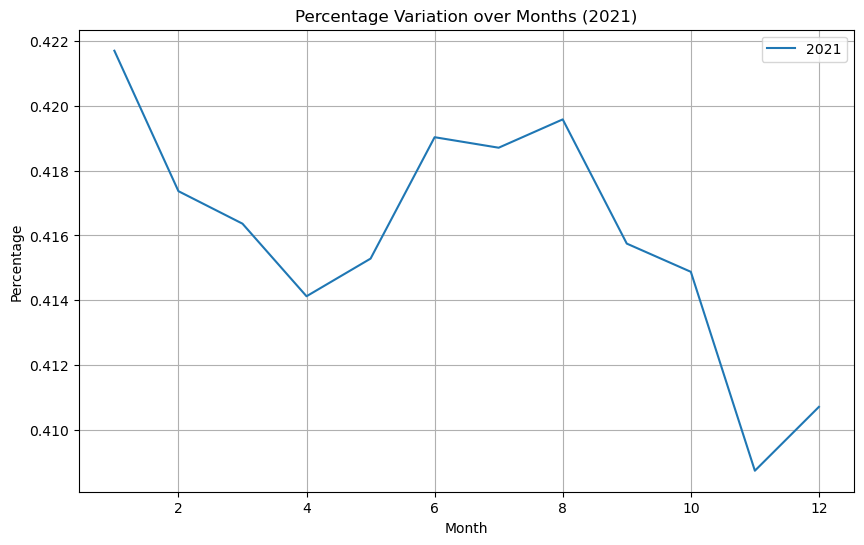

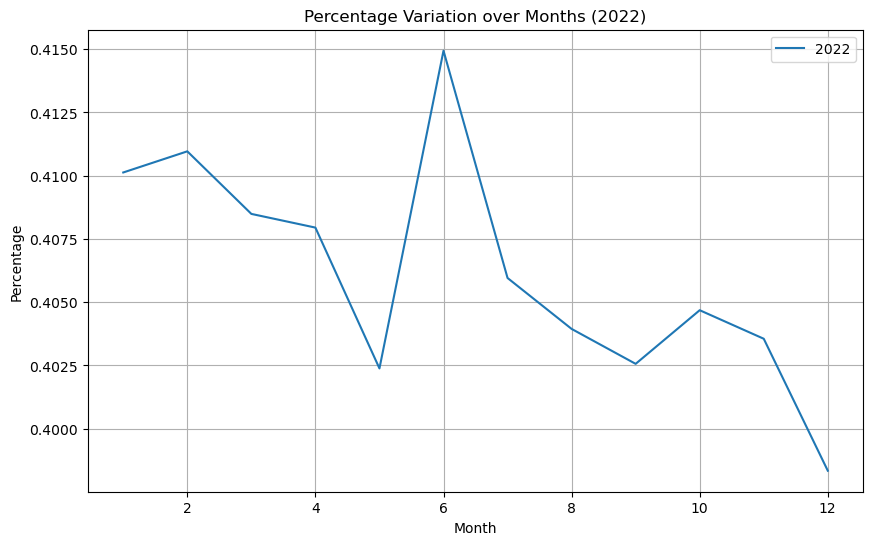

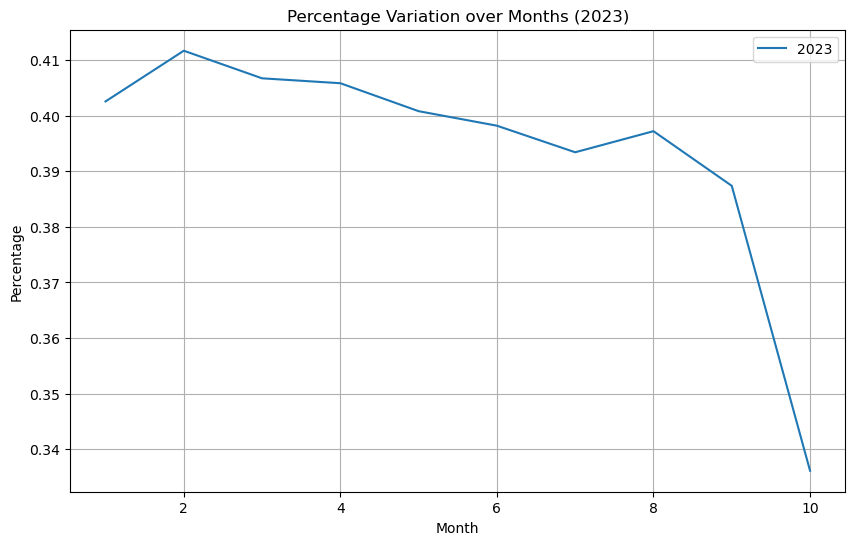

In [93]:
# Plotting PERCENTAGE for each year
plt.figure(figsize=(10, 6))
plt.plot(data_2021['MONTH'], data_2021['PERCENTAGE'], label='2021')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('Percentage Variation over Months (2021)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data_2022['MONTH'], data_2022['PERCENTAGE'], label='2022')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('Percentage Variation over Months (2022)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data_2023['MONTH'], data_2023['PERCENTAGE'], label='2023')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('Percentage Variation over Months (2023)')
plt.legend()
plt.grid(True)
plt.show()

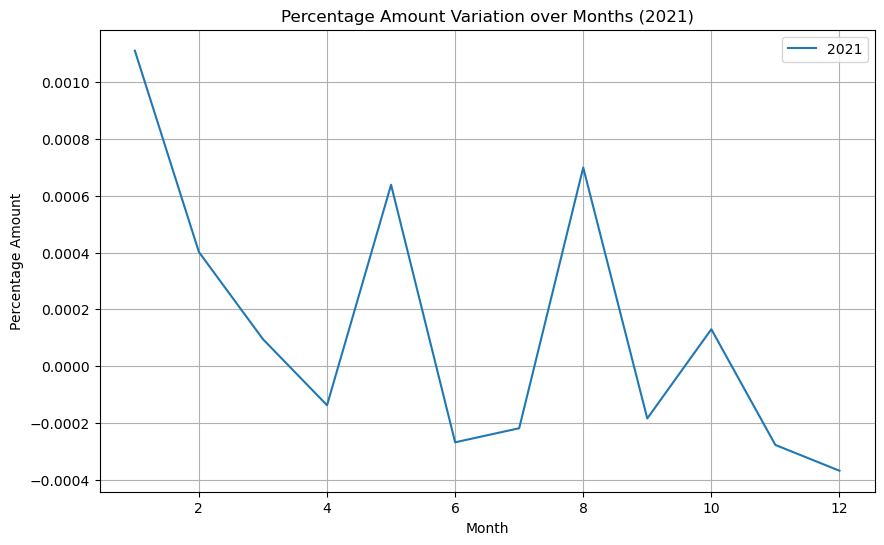

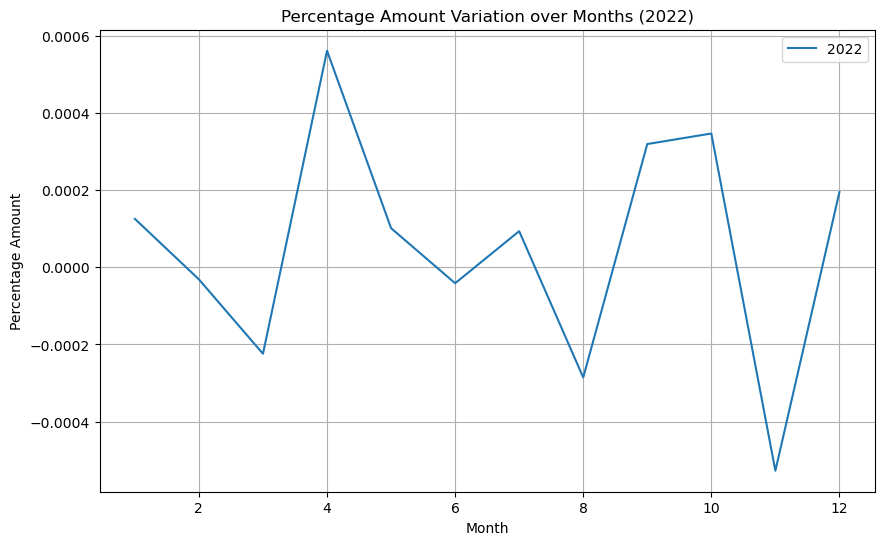

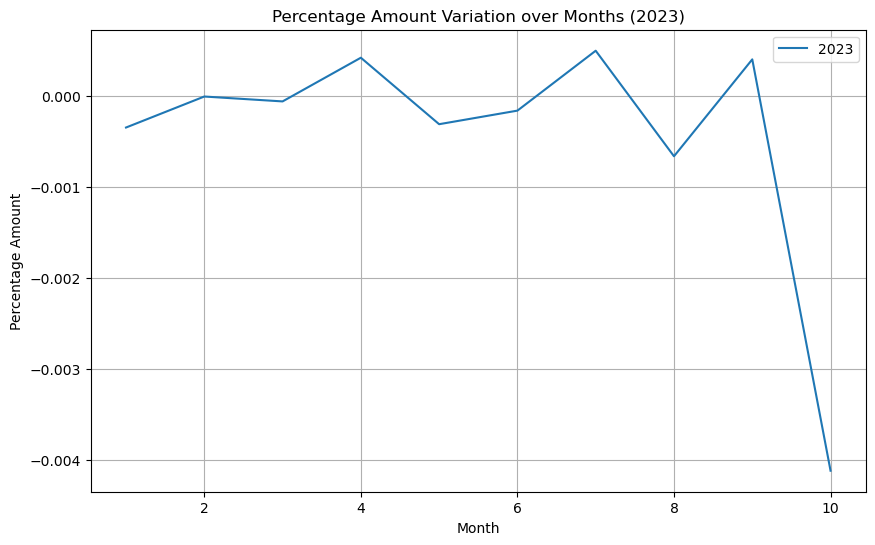

In [94]:
# Plotting PERCENTAGE_AMOUNT for each year
plt.figure(figsize=(10, 6))
plt.plot(data_2021['MONTH'], data_2021['PERCENTAGE_AMOUNT'], label='2021')
plt.xlabel('Month')
plt.ylabel('Percentage Amount')
plt.title('Percentage Amount Variation over Months (2021)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data_2022['MONTH'], data_2022['PERCENTAGE_AMOUNT'], label='2022')
plt.xlabel('Month')
plt.ylabel('Percentage Amount')
plt.title('Percentage Amount Variation over Months (2022)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data_2023['MONTH'], data_2023['PERCENTAGE_AMOUNT'], label='2023')
plt.xlabel('Month')
plt.ylabel('Percentage Amount')
plt.title('Percentage Amount Variation over Months (2023)')
plt.legend()
plt.grid(True)
plt.show()

We reviewed several operations with VIAM, making SQL queries to visualize and track if the cancellations have their reverse operation to compensate, and what we found is that although in most cases those cancellations do not impact on the same day but can take up to a couple of weeks, finally if they run

It is considered that having a small positive deviation is convenient for the company's operation.